In [111]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
import pandas as pd
import nltk
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from nltk.tokenize.regexp import RegexpTokenizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import re

In [112]:
%matplotlib inline

<h3>A. Прочитаем данные</h3>

In [4]:
df = pd.read_csv('Emails.csv')

<h3>В. Посмотрим на содержимое датасета</h3>
<h4><p>Можно заметить, что документы распаршены очень некачественно. Поэтому будем использовать поле RawText</p></h4>

In [5]:
df.head()

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


<h3> C. Проведем предобработку
</h3>
<h4><p>Вырежем служебные пометки, не важные для разделения на кластеры (regexpr честно взят у @standy66).</p></h4>

In [61]:
def parse(text):
    text = re.sub(r'[\x00-\x08\x0b\x0c\x0e-\x1f\x7f-\xff]', '', text)
    text = re.sub(r"STATE-\w+", "", text)
    text = re.sub(r"UNCLAS.*?NO FOIA WAIVER\.", "", text, flags=re.S)
    text = re.sub(r"^UNCLASSIFIED.*$", "", text, flags=re.M)
    text = re.sub(r"^PART \w+$", "", text, flags=re.M)
    text = re.sub(r"^RELEASE IN\s{0,1}\w*$", "", text, flags=re.M)
    text = re.sub(r"^RELEASE IN PART\s{0,1}\w*$", "", text, flags=re.M)
    text = re.sub(r"^From.*$", "", text, flags=re.M)
    text = re.sub(r"^Sent.*$", "", text, flags=re.M)
    text = re.sub(r"^To.*$", "", text, flags=re.M)
    text = re.sub(r"^Cc.*$", "", text, flags=re.M)
    text = re.sub(r"^Subject.*$", "", text, flags=re.M)
    text = re.sub(r"^B\d{1}$", "", text, flags=re.M)
    text = re.sub(r"^[-—]*\s{0,1}Original Message\s{0,1}[-—]*$", "", text, flags=re.M)
    text = re.sub(r"^CONFIDENTIAL$", "", text, flags=re.M)
    text = re.sub(r"^For.*$", "", text, flags=re.M)
    text = re.sub(r"^Fw.*$", "", text, flags=re.M)
    text = re.sub(r"^.*SENSITIVE BUT UNCLASSIFIED.*$", "", text, flags=re.M)
    text = re.sub(r"^Importance.*$", "", text, flags=re.M)
    return "\n".join(re.split(r"\n*", text)).strip()

/home/konstagapov/.env/p3env/lib/python3.5/re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


'What a wonderful, strong and moving statement by your boss. please tell her how much Sen. McCain appreciated it. Me\ntoo'

In [63]:
feature_text = df['RawText'].fillna('').apply(parse)

/home/konstagapov/.env/p3env/lib/python3.5/re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [64]:
print(feature_text.iloc[4])

Attachments:
H <hrod17@clintonemail.com>
Friday, March 11, 2011 1:36 PM
Huma Abedin
hrc memo syria aiding libya 030311.docx
Pis print.
March 3, 2011
Re: Syria aiding Qaddafi
This memo has two parts. Part one is the report that Syria is providing air support for Qaddafi. Part two is a note
to Cody from Lord David Owen, former UK foreign secretary on his views of an increasingly complex crisis. It
seems that the situation is developing into a protracted civil war with various nations backing opposing sides
with unforeseen consequences. Under these circumstances the crucial challenge is to deprive Qaddafi of his
strategic depth—his support both financial and military.
I. Report
During the afternoon of March 3, advisers to Muammar Qaddafi stated privately that the Libyan
Leader has decided that civil war is inevitable, pitting troops and mercenary troops loyal to him
against the rebel forces gathering around Benghazi. Qaddafi is convinced that these rebels are
being supported by the United

<h3> D. Найдем самые частовстречающиеся биграммы </h3>

In [155]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
text_list = " ".join(entry for entry in feature_text).split()
finder = BigramCollocationFinder.from_words(text_list)       
for colloc in finder.nbest(bigram_measures.raw_freq, 20):
    print(" ".join(colloc))

of the
in the
to the
on the
and the
for the
that the
with the
to be
at the
will be
by the
is a
from the
of a
the United
as a
has been
in a
United States


<h4> В основном самые употребляемые биграммы состоят из предлогов, артиклей и вспомогательных глаголов, что логично. </h4>

<h3>E. Найдем самые коллокации из 2х слов с самым высоким pmi</h3>

In [157]:
for colloc in finder.nbest(bigram_measures.pmi, 20):
    print(" ".join(colloc))

!- .112
!.:tam Trir...‘11
!.ai rati.aft?
!Carnal Lakhdhir
!Dosi',. --;
!USA Obamalrnprimer
!act davc
!■141NTEE113N Finec.6)FiEitrig,
"'""; ";
"'muscatinel@state.gov'" <muscatinel@state.gov>
"'scwarzericp@state.gov'" <scwarzericp@state.gov
"(3). .Serve
"(j) DEFINITIONS.—In
"114, t:u
"22 '014-20439
"4.ii J14,1
"5 Pillars
"60 MINUTES"
"Afghanistan: Sustaining
"Alive, Alive!


<h4> Получили много редкого мусора, который получил завышенный PMI. Наложим ограничение на минимальную частоту употребления, чтобы этого избежать. </h4>

In [158]:
finder.apply_freq_filter(100)
for colloc in finder.nbest(bigram_measures.pmi, 20):
    print(" ".join(colloc))




Sinn Fein
Reason: 1.4(B),
Class: CONFIDENTIAL
A/GIS, DoS
Declassify on:
DAS, A/GIS,
(Source Comment:
OFFICE TIME
2201 C
Watch Officer
Human Rights
Sullivan, Jacob
Lona Valmoro
D <MillsCD@state.gov>
Northern Ireland
per cent
Private Residence
SECRETARY CLINTON:
Jacob J
prime minister


<h4> Результат стал адекватней - увеличим порог </h4>

In [159]:
finder.apply_freq_filter(200)
for colloc in finder.nbest(bigram_measures.pmi, 20):
    print(" ".join(colloc))


Private Residence
SECRETARY CLINTON:
*En route
RELEASE IN
IN PART
Mills, Cheryl
Conference Room
Middle East
Washington, DC
Cheryl D
human rights
New York
health care
Prime Minister
White House
Secretary's Office
United States
United Nations
Let me
rather than


<h4> Получили слова, которые обычно употребляются парами </h4>

<h3> F. Простая кластеризация </h3>

In [114]:
vectorizer = TfidfVectorizer(max_df=0.7, min_df=50, max_features=10000)
features = vectorizer.fit_transform(feature_text)

In [162]:
labels = DBSCAN(min_samples=20, metric='cosine', algorithm='brute', n_jobs=-1).fit_predict(features)
unique_labels = np.unique(labels)

In [117]:
def get_samples(label, texts, labels):
    return [(i, texts[i]) for i, l in enumerate(labels) if l == label]
    

In [118]:
for lbl in unique_labels:
    samples = get_samples(lbl, feature_text, labels)
    print(lbl, len(samples))
    print('-' * 25 + '\n')
    for i, txt in samples[:5]:
        print (txt)
        print ('\n\n\n')
        print ('-' * 50)

-1 6655
-------------------------

What a wonderful, strong and moving statement by your boss. please tell her how much Sen. McCain appreciated it. Me
too




--------------------------------------------------
Thx
as our soldiers do. Thinking of you and Pat and everyone this morning.
AM




--------------------------------------------------
FYI -
Shea, Peter T
All,
ADS
Aaron D. Snipe
Spokesperson I Bureau of Near Eastern Affairs I U.S. Department of State
 
Office: +1 202-647-9533 I Email: snipead@state.gov
cc: Mitchell, Andrew B




--------------------------------------------------
Pis print.
-•-...-^
H < hrod17@clintonernailcom>
Wednesday, September 12, 2012 2:11 PM
Russorv@state.gov'
htte/maxbiumenthal.com12012/09/meet-the-right-wing-extremist-behind-anti-musiim-tihn-that-sparked-
deadly-riots/




--------------------------------------------------
Anti-Muslim film director in hiding, following
Libya, Egypt violence
By Nia-Malika Henderson and Michelle Boorstein, Updated: Wednesday

<h4><p> В целом, кластеризация получилась достаточно понятная: </p>
<p> 0: О Ливии и Каддафи </p>
<p> 1: Расписания </p>
<p> 2: Конфиденциальные письма </p>
<p> 3: Короткие личные сообщения </p>
<p> 4: "Sensitive But Unclassified" письма - не проследил общих черт в содержании</p>
<p> 5: Переписка с "Филом" </p>
<p> 6: Касается советника по юр.делам Гарольда</p>
<p> 7: Вызваны Northern Ireland agrees power-sharing deal в 2010 году<p>
<p> 8: Предупреждения о being out of the office </p>

In [119]:
samples = get_samples(4, feature_text, labels)
print(lbl, len(samples))
print('-' * 25 + '\n')
for i, txt in samples[:20]:
    print (txt)
    print ('\n\n\n')
    print ('-' * 50)

8 31
-------------------------

What does this mean?
'From: Abedin, Huma <AbedinH@state.gov>
(SBU) Embassy Amman reports a royal decree was issued naming HRH Prince Hussein Ben Abdullah as Crown Prince as
of today.
Automatic electronic distribution to: S, D(S), D(L), P. E, C, M, DG, T, R, PA, G, AF, EAP, EUR, NEA, SCA, WHA,I0, S/CRS,
S/CT, H, DS, CA, PMAT, INR, IIP, CMS, S/ES, S/ES-0, NSOC, and WHSR.




--------------------------------------------------
What's Hussein like?
Isn't a surprise since 5 years ago he removed his brother as official crown prince.
Basically he's not honoring his fathers dying wish but since constitution says it should be son (with brother as option) he
has clear authority to do it. I personally think this shows confidence in his position as he's not worried about an outcry
from his fathers loyalists.
What does this mean?
(SBU) Embassy Amman reports a royal decree was issued naming HRH Prince Hussein Ben Abdullah as Crown Prince as
of today.
Automatic electron

<h4><p>Похоже, что в 4 кластер попали сообщения, содержащие сообщения от посольств и сообщения, связанные с назначением Hussein Ben Abdullah кронпринцем. </p></h4>


<h3> G. Попробуем понизить размерность и показать кластеры на плоскости. Воспользуемся TSNE. </h3>
<h4> Оставим только большие кластеры </h4>

In [165]:
labels = DBSCAN(min_samples=60, metric='cosine', algorithm='brute', n_jobs=-1).fit_predict(features)
unique_labels = np.unique(labels)

In [167]:
s0, s1, s2 = get_samples(0, feature_text, labels), get_samples(1, feature_text, labels), get_samples(2, feature_text, labels)

In [172]:
color = np.linspace(0.0, 1, len(unique_labels))

In [168]:
indexes0 = [ s[0] for s in s0]
indexes1 = [ s[0] for s in s1]
indexes2 = [ s[0] for s in s2]
show_labels = len(indexes0) * [0] + len(indexes1) * [1] + len(indexes2) * [2]

In [122]:
tsne = TSNE()
tsne_feat = tsne.fit_transform(features.toarray())

In [169]:
print(len(s0), len(s1), len(s2))


735 111 61


<h4> Розовый - Каддафи, Желтый - timetables, Красный - Конфиденциальные письма </h4>

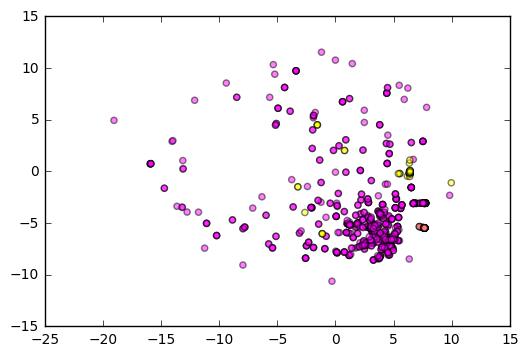

In [173]:
plt.scatter(tsne_feat[np.array(indexes0 + indexes1 + indexes2), 0], 
            tsne_feat[np.array(indexes0 + indexes1 + indexes2), 1],
            c=color[show_labels][:], cmap=plt.cm.spring, alpha=0.5)

<h4> Основная часть кластеров остается кучной при проекции на R^2, однако часть точек отбрасывает. </h4> 

<h3> H. Использование других методов кластеризации дало похожее разбиение. KMeans разделил на кластеры по размеру сообщений, но различные по содержанию. </h3>

<h3>I. Оценка интерпретируемости с помощью асессоров: </h3>
<h4><p>Проблемы использования асессора: </p></h4>
<p>1) Он один -> отсутствие стат.значимости </p>
<p>2) Его мнение о "схожести" документов меняется со временем (мнение о "похожести" определяется знаниями о наборе текстов )</p>
<p>3)Человеку сложно объективно разделить большое количество текстов на кластеры, особенно в случае схожей тематики</p>
<p>4) Кластеры могут быть объединены по слишком общему признаку, который покажется асессору недостаточным(например, тексты о спортивных мероприятиях, в которые объединены новости про нового чемпиона UFC и про матч Карлсен - Карякин.</p>
<h4> Как можно оценивать: </h4>
<p>Из каждого кластера $K$ выбрать несколько текстов {$T_{i,K}$}</p>
<p>Для каждого предложить упорядочить список из 2 * M случайных текстов(по 2 из каждого кластера, M - количество наших кластеров)по похожести на данный текст.</p>
<p>Повторить 2 раза, чтобы сбалансировать оценку похожести</p>
<p>Посчитать среднее значение в "ряду похожести" для "правильных" пар по представителям каждого кластера.</p>
<p>Чем меньше полученная величина - тем лучше</p>
<p>Преимущество перед выбором "За/Против":</p>
<p>1)Не работает "принцип значения по умолчанию", т.к. мы не предлагаем асессору ответ.</p>
<p>2)Асессору не нужно калибровать мнение о похожести</p>
<p>С другой стороны, мы не просим делить тексты на кластеры самостоятельно, что позволяет избежать длительной подготовки асессора.</p>
<p>2 элемента из одного кластера в одном раунде оценки помогут избежать выбросов</p>
    